<img src="../../figures/logo-esi-sba.png" width="700" height="126" align="center" alt="Logo">

# Book recommendation system
*Prepared by* 
- Benghenima Hafsa (h.benghenima@esi-sba.dz) 
- Ghandouz Amina (a.ghandouz@esi-sba.dz) 
- Benahmed Firdaws (f.benahmed@esi-sba.dz) 

## Notebook3 : Apriori Algorithm

### Packages

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

### Load Data

In [2]:
df = pd.read_csv("../../data/cleaned_df.csv")
df

,User-ID,ISBN,Book-Rating,Book-Title
0,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...
1,276744,038550120X,7,A Painted House
2,276747,0060517794,9,Little Altars Everywhere
3,276747,0671537458,9,Waiting to Exhale
4,276747,0679776818,8,Birdsong: A Novel of Love and War
...,...,...,...,...
321073,276704,0345386108,6,Winter Moon
321074,276704,0743211383,7,Dreamcatcher
321075,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...
321076,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback))


### Prepare the Data

We need to transform the data into a transactional format, where each row represents a user_id and the books they have interacted with.

In [3]:
# Group by userID and aggregate bookTitles
grouped_df = df.groupby('User-ID')['Book-Title'].apply(list).reset_index()
transactional_df = pd.DataFrame(grouped_df['Book-Title'].tolist(), index=grouped_df['User-ID']).reset_index()
transactional_df.columns = ['User-ID'] + [f'Book{i+1}' for i in range(transactional_df.shape[1]-1)]
transactional_df.tail()

,User-ID,Book1,Book2,Book3,Book4,Book5,Book6,Book7,Book8,Book9,...,Book5488,Book5489,Book5490,Book5491,Book5492,Book5493,Book5494,Book5495,Book5496,Book5497
61283,278846,Brave New World,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
61284,278849,Behind the Attic Wall (Avon Camelot Books (Pap...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
61285,278851,The Bachelor Home Companion: A Practical Guide...,Murphy's Law Book Two: More Reasons Why Things...,Why stop?: A guide to Texas historical roadsid...,The Are You Being Served? Stories: 'Camping In...,1996-97 Texas Almanac and State Industrial Gui...,Life's Little Instruction Book (Life's Little ...,"Dallas Street Map Guide and Directory, 2000 Ed...","Highpoint Adventures, A Pocket Guide to the 50...",None,...,None,None,None,None,None,None,None,None,None,None
61286,278852,Dave Barry's Only Travel Guide You'll Ever Need,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
61287,278854,Final Harvest : Poems,A Virtuous Woman (Oprah's Book Club (Paperback)),Hornet's Nest,Kat Scratch Fever (Kat Colorado Mysteries),In Her Day,Ashes to Ashes,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [4]:
# Group by userID and aggregate bookTitles
transactional_df = df.groupby('User-ID')['Book-Title'].apply(list).reset_index()
transactional_df.head()

,User-ID,Book-Title
0,8,"[The Witchfinder (Amos Walker Mystery Series),..."
1,9,[Beloved (Plume Contemporary Fiction)]
2,12,[If I'd Known Then What I Know Now: Why Not Le...
3,14,[Flood : Mississippi 1927]
4,16,[Airframe]


In [5]:
transactional_df.shape

(61288, 2)

This transactional_df is just for visualizing and understand what happen in details but in reality Apriori algo needs list of transactions (one transaction = books read by a user).


In [6]:
transactions = df.groupby('User-ID')['Book-Title'].apply(list).tolist()

# Remove transactions with one book because we don't need it
transactions = [transaction for transaction in transactions if len(transaction) > 1]
transactions

[['The Witchfinder (Amos Walker Mystery Series)',
  'More Cunning Than Man: A Social History of Rats and Man',
  'Goodbye to the Buttermilk Sky'],
 ['Death in the Clouds', 'Piercing the Darkness'],
 ['To Kill a Mockingbird', 'Seabiscuit: An American Legend'],
 ['Icebound', "I'll Be Seeing You"],
 ["All the King's Men", 'Pacific Northwest', 'A Soldier of the Great War'],
 ['LONESOME DOVE', 'Haveli (Laurel Leaf Books)'],
 ['Team Bush : Leadership Lessons from the Bush White House',
  'The Right Man : The Surprise Presidency of George W. Bush'],
 ['El Senor De Los Anillos: LA Comunidad Del Anillo (Lord of the Rings (Spanish))',
  'El Senor De Los Anillos: Las DOS Torres (Lord of the Rings (Paperback))',
  'El Senor De Los Anillos: El Retorno Del Rey (Tolkien, J. R. R. Lord of the Rings. 3.)'],
 ['Fast Women',
  'Female Intelligence',
  "Pasquale's Nose: Idle Days in an Italian Town",
  "Prize Stories, 1987: The O'Henry Awards",
  'Rich Dad, Poor Dad: What the Rich Teach Their Kids About M

### Apply Apriori Algorithm 

In [7]:
def apriori_optimized_with_tracking(transactions, min_support, min_confidence):
    # Convert transactions to one-hot encoded DataFrame
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Find frequent itemsets
    frequent_itemsets_df = apriori(
        df, 
        min_support=min_support/len(transactions), 
        use_colnames=True
    )
    
    # Convert frequent itemsets to dictionary format
    frequent_itemsets = {}
    for _, row in frequent_itemsets_df.iterrows():
        itemset = frozenset(row['itemsets'])
        support = row['support'] * len(transactions)
        frequent_itemsets[itemset] = support
    
    # Track pruning steps 
    pruning_steps = [
        len([k for k in frequent_itemsets if len(k) == i]) 
        for i in range(1, max(len(k) for k in frequent_itemsets) + 1)
    ]
    
    # Workaround for different mlxtend versions
    try:
        # Try new method without num_itemsets
        rules_df = association_rules(
            frequent_itemsets_df, 
            metric="confidence", 
            min_threshold=min_confidence
        )
    except TypeError:
        # Fallback for older versions
        rules_df = association_rules(
            frequent_itemsets_df, 
            metric="confidence", 
            min_threshold=min_confidence, 
            num_itemsets=len(frequent_itemsets_df)
        )
    
    # Convert rules to the format in the original implementation
    association_rules_list = []
    for _, row in rules_df.iterrows():
        antecedent = frozenset(row['antecedents'])
        consequent = frozenset(row['consequents'])
        confidence = row['confidence']
        association_rules_list.append((antecedent, consequent, confidence))
    
    return frequent_itemsets, association_rules_list, pruning_steps

In [8]:
min_support=60
min_confidence=0.5

frequent_itemsets, association_rules, pruning_steps = apriori_optimized_with_tracking(
    transactions, 
    min_support, 
    min_confidence
)
    
print("Frequent Itemsets:")
for itemset, support in frequent_itemsets.items():
    print(f"Itemset: {itemset}, Support: {support}")
    
print("\nAssociation Rules:")
for antecedent, consequent, confidence in association_rules:
    print(f"{antecedent} => {consequent}, Confidence: {confidence:.2f}")
    
print("\nPruning Steps:")
for step, count in enumerate(pruning_steps, 1):
    print(f"Step {step}: {count} frequent itemsets")

Frequent Itemsets:
Itemset: frozenset({'1984'}), Support: 117.0
Itemset: frozenset({'1st to Die: A Novel'}), Support: 174.0
Itemset: frozenset({'2nd Chance'}), Support: 120.0
Itemset: frozenset({'A Bend in the Road'}), Support: 106.0
Itemset: frozenset({'A Child Called \\It\\": One Child\'s Courage to Survive"'}), Support: 97.0
Itemset: frozenset({'A Heartbreaking Work of Staggering Genius'}), Support: 89.0
Itemset: frozenset({'A Is for Alibi (Kinsey Millhone Mysteries (Paperback))'}), Support: 81.0
Itemset: frozenset({'A Map of the World'}), Support: 70.0
Itemset: frozenset({'A Painted House'}), Support: 234.0
Itemset: frozenset({'A Prayer for Owen Meany'}), Support: 138.0
Itemset: frozenset({'A Time to Kill'}), Support: 174.0
Itemset: frozenset({'A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail)'}), Support: 67.0
Itemset: frozenset({'A Walk to Remember'}), Support: 112.00000000000001
Itemset: frozenset({'A Widow for One Yea

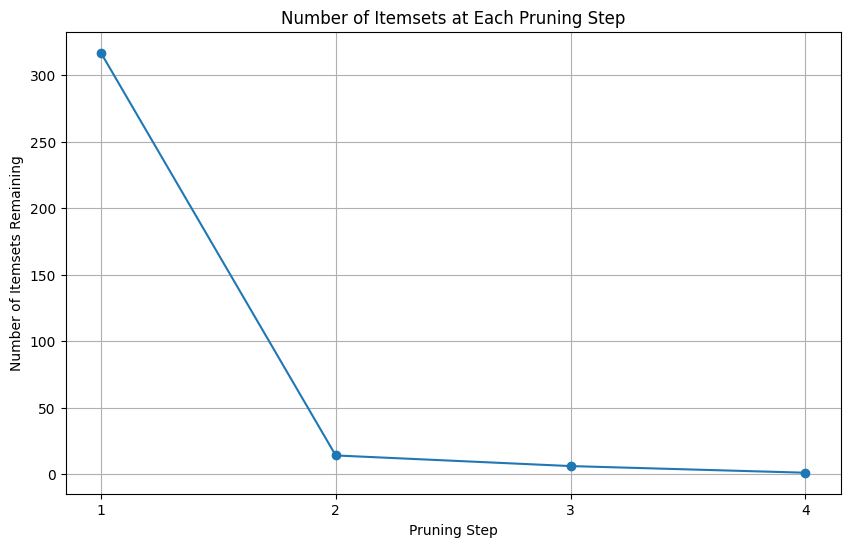

In [9]:
#Plot the number of itemsets remaining after each pruning step
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pruning_steps) + 1), pruning_steps, marker='o')
plt.title('Number of Itemsets at Each Pruning Step')
plt.xlabel('Pruning Step')
plt.ylabel('Number of Itemsets Remaining')
plt.xticks(range(1, len(pruning_steps) + 1))  # Set x-ticks to match the number of pruning steps
plt.grid(True)
plt.show()

In [22]:
def recommend_books(book, association_rules):

    recommendations = set()
    normalized_book = book.strip().lower()

    for antecedent, consequent, confidence in association_rules:
        normalized_antecedent = set(item.strip().lower() for item in antecedent)
        if normalized_book in normalized_antecedent:
            recommendations.update(consequent)

    recommendations = {rec for rec in recommendations if rec.strip().lower() != normalized_book}

    if not recommendations:
        print(f"No recommendations found for '{book}'. It might not be part of any antecedents.")
    return list(recommendations)

# Example usage
input_book = "Harry Potter and the Sorcerer's Stone (Book 1)"
suggested_books = recommend_books(input_book, association_rules)

print(f"Recommendations for '{input_book}':")
if suggested_books:
    for rec in suggested_books:
        print(f"- {rec}")


Recommendations for 'Harry Potter and the Sorcerer's Stone (Book 1)':
- Harry Potter and the Goblet of Fire (Book 4)
- Harry Potter and the Chamber of Secrets (Book 2)
- Harry Potter and the Prisoner of Azkaban (Book 3)
